In [1]:
# !pip install pmdarima

In [2]:
## Imports for connection with Azure SQL Database Server
import pyodbc
from sqlalchemy import create_engine

In [3]:
## Importing Libraries and Tools for EDA and predictive Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

## **Data Collection**

In [5]:
## Connection details to establish the connection

server = "qaececrm-s2.database.windows.net"
database = "QAECECRM_S2"
username = "dbadmin"
password = "DashTech1234"

## Connection String to establsifh connection
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server'

## Establising the connection using sqlalchemy with creat_engine
engine = create_engine(connection_string)

### **1. Query's for Data Retrieval**

In [6]:
## WE are only Taking Dates after year 2000, we came to this conclusion because of EDA.
Contract_TQ = """
Select c.ContractId, c.AgentId, o.Abbreviation as Office, et.Name as EventType, at.Name as ActType, c.VenueName, c.VenuePhysicalCity, c.ContractDueDate, c.Gross
From [dbo].[Contract] c
JOIN [dbo].[LuOffice] o ON c.OfficeId = o.OfficeId
JOIN [dbo].[LuEventType] et ON c.EventTypeId = et.EventTypeId
JOIN [dbo].[ContractArtist] ca ON c.ContractId = ca.ContractId
JOIN [dbo].[ArtistActType] aat ON aat.ArtistId = ca.ArtistId
JOIN [dbo].[LuActType] at ON aat.ActTypeId = at.ActTypeId
Where Year(c.ContractDueDate) >= 2000 AND Year(c.ContractDueDate) < 2024 
Order By c.ContractDueDate
"""

## Agent Profits by payment logs
AgentPL_TQ = """
Select AgentId, GrossAmount, NetAmount, GrossAmount - NetAmount as Profit, ReceivedDate
From [dbo].[AgentPayrollLog]
Where Year(ReceivedDate) >= 2000 AND Year(ReceivedDate) < 2024 
Order By ReceivedDate
"""

In [7]:
Contract_df = pd.read_sql(Contract_TQ, engine)
Contract_df.head(10)

,ContractId,AgentId,Office,EventType,ActType,VenueName,VenuePhysicalCity,ContractDueDate,Gross
0,151686,313,RIC,Club,Bands,"LIGHTFOOTS, HYATT RICHMOND",RICHMOND,2000-01-01,1900.0
1,152066,397,RIC,Dance,Bands,NATIONAL MUSEUM OF WOMEN IN THE ARTS,WASHINGTON,2000-01-01,500.0
2,152200,196,RIC,Christmas Party,DJs,HOLIDAY INN 1776,RICHMOND,2000-01-01,100.0
3,152201,277,RIC,Christmas Party,Soloist/Duos/Trios,THORNBERG RESIDENCE IN THE COUNTRY CLUB HILL S...,ASHLAND,2000-01-01,350.0
4,152208,313,RIC,Dance,Bands,CATHOLIC CHURCH PAVILLION,SOUTH HILL,2000-01-01,10000.0
5,152209,419,RIC,Dance,Rock,"TAZEWELL ROOM, KINGSMILL RESORT AND CONFERENCE...",WILLIAMSBURG,2000-01-01,4975.0
6,152209,419,RIC,Dance,International,"TAZEWELL ROOM, KINGSMILL RESORT AND CONFERENCE...",WILLIAMSBURG,2000-01-01,4975.0
7,326868,413,ATL,Other,Nationals,THE MUSEUM OF NATURAL HISTORY,NEW YORK,2000-01-01,55000.0
8,326879,134,ATL,Dance,Bands,MAISON AND JARDIN,ORLANDO,2000-01-01,1500.0
9,253880,192,CLT,Club,Bands,RED'S,RALEIGH,2000-01-03,1000.0


In [8]:
AgentPL_df = pd.read_sql(AgentPL_TQ, engine)
AgentPL_df.head(10)

,AgentId,GrossAmount,NetAmount,Profit,ReceivedDate
0,419,135.0,54.0,81.0,2000-01-03
1,110,200.0,80.0,120.0,2000-01-04
2,110,200.0,80.0,120.0,2000-01-04
3,122,25.0,7.5,17.5,2000-01-04
4,125,1400.0,490.0,910.0,2000-01-04
5,134,2000.0,600.0,1400.0,2000-01-04
6,163,400.0,140.0,260.0,2000-01-04
7,187,450.0,157.5,292.5,2000-01-04
8,187,250.0,87.5,162.5,2000-01-04
9,188,700.0,280.0,420.0,2000-01-04


### **2. Analyzing the tables**

#### 1. Agent Payroll Table

In [9]:
# Ensure 'ReceivedDate' is in datetime format
AgentPL_df['ReceivedDate'] = pd.to_datetime(AgentPL_df['ReceivedDate'])

# Step 1: Create a Year-Week column using the correct weekly format
AgentPL_df['YearWeek'] = AgentPL_df['ReceivedDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Step 2: Group by 'YearWeek' and sum 'Profit'
profit_grouped_df = AgentPL_df.groupby(['YearWeek'])['Profit'].sum().reset_index()

# Step 3: Fill NaN values with 0 if needed (optional)
profit_grouped_df['Profit'] = profit_grouped_df['Profit'].fillna(0)


In [10]:
# Display the first few rows
profit_grouped_df['YearWeek'] = pd.to_datetime(profit_grouped_df['YearWeek'])
profit_grouped_df.tail(10)


,YearWeek,Profit
1228,2023-07-17,259828.74
1229,2023-07-24,100812.41
1230,2023-07-31,111114.98
1231,2023-08-07,170757.80
1232,2023-08-14,125873.90
1233,2023-08-21,140254.96
1234,2023-08-28,236143.17
1235,2023-09-04,1900.00
1236,2023-10-16,4850.00
1237,2023-10-23,2850.00


In [11]:
profit_grouped_df = profit_grouped_df[:-4]
profit_grouped_df.reset_index(drop=True, inplace=True)
profit_grouped_df.tail(10)

,YearWeek,Profit
1224,2023-06-19,265334.50
1225,2023-06-26,174365.24
1226,2023-07-03,146128.33
1227,2023-07-10,58071.82
1228,2023-07-17,259828.74
1229,2023-07-24,100812.41
1230,2023-07-31,111114.98
1231,2023-08-07,170757.80
1232,2023-08-14,125873.90
1233,2023-08-21,140254.96


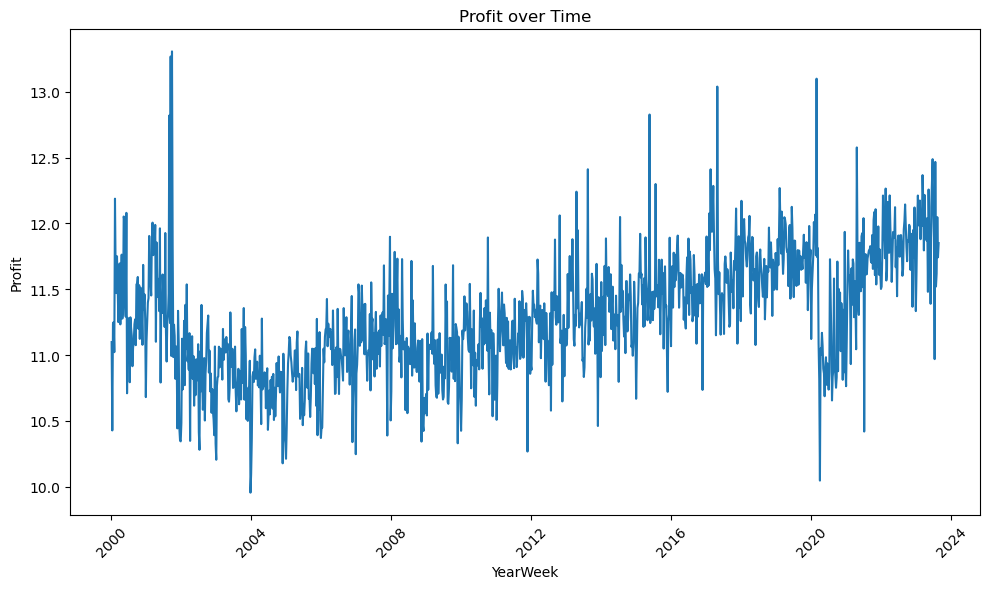

In [12]:

# Assuming profit_grouped_df is your DataFrame

# Convert 'YearWeek' and 'Profit' to NumPy arrays before plotting
yearweek_array = profit_grouped_df['YearWeek'].to_numpy()  # Converting YearWeek to numpy array
profit_array = profit_grouped_df['Profit'].to_numpy()  # Converting Profit to numpy array
profit_array = np.log(profit_array + 1)

# Ensure there are no invalid values
profit_grouped_df = profit_grouped_df.dropna()

# Plotting using the numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(yearweek_array[:, None], profit_array)  # Using numpy arrays for multi-dimensional indexing

# Set the x-axis format for dates and adjust limits
plt.gca().xaxis_date()  # Ensure x-axis is treated as dates
plt.xlabel('YearWeek')
plt.ylabel('Profit')
plt.title('Profit over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [13]:
profit_series = profit_grouped_df['Profit']
profit_series = np.log(profit_series + 1)

In [14]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(profit_series)

# Print ADF statistics
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpretation:
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing might be required.")
else:
    print("The data is stationary.")

ADF Statistic: -2.0449845027369817
p-value: 0.2672037002372867
The data is non-stationary. Differencing might be required.


In [15]:
# Apply first-order differencing to log-transformed data
profit_series = profit_series.diff().dropna()  # Drop NA values caused by differencing

In [16]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(profit_series)

# Print ADF statistics
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpretation:
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing might be required.")
else:
    print("The data is stationary.")

ADF Statistic: -12.116467257911086
p-value: 1.867469536531998e-22
The data is stationary.


In [17]:
# Define the split point (for example, the last 20% of data as test set)
train_size = int(len(profit_series) * 0.8)
train, test = profit_series[:train_size], profit_series[train_size:]

# Print the lengths of the train and test sets
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 986, Test size: 247


In [147]:
# model = ARIMA(profit_grouped_df['Profit'], order=(2, 1, 25))
# arima_result = model.fit()

In [18]:
# Seasonal Auto-ARIMA model (adjust m for your seasonal period, e.g., m=12 for monthly seasonality)
auto_model_seasonal = auto_arima(train, seasonal=True, m=26, trace=True, suppress_warnings=True)

# Forecast the next 10 periods (or as many as you need)
forecast_seasonal = auto_model_seasonal.predict(n_periods=len(test))

# Calculate the accuracy for seasonal model
mae_seasonal = mean_absolute_error(test, forecast_seasonal)
mse_seasonal = mean_squared_error(test, forecast_seasonal)
rmse_seasonal = np.sqrt(mse_seasonal)
mape_seasonal = np.mean(np.abs((test - forecast_seasonal) / test)) * 100

# Print the seasonal model's accuracy
print(f"MAE (seasonal): {mae_seasonal}")
print(f"MSE (seasonal): {mse_seasonal}")
print(f"RMSE (seasonal): {rmse_seasonal}")
print(f"MAPE (seasonal): {mape_seasonal}%")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=965.484, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=639.341, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=476.133, Time=0.99 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=963.486, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=476.727, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[26] intercept   : AIC=inf, Time=3.58 sec
 ARIMA(0,0,1)(0,0,2)[26] intercept   : AIC=423.762, Time=4.56 sec
 ARIMA(0,0,1)(1,0,2)[26] intercept   : AIC=378.189, Time=15.12 sec
 ARIMA(0,0,1)(2,0,2)[26] intercept   : AIC=inf, Time=12.74 sec
 ARIMA(0,0,1)(2,0,1)[26] intercept   : AIC=374.078, Time=9.39 sec
 ARIMA(0,0,1)(2,0,0)[26] intercept   : AIC=406.784, Time=5.48 sec
 ARIMA(0,0,1)(1,0,0)[26] intercept   : AIC=474.748, Time=0.79 sec
 ARIMA(0,0,0)(2,0,1)[26] intercept   : AIC=939.487, Time=3.23 sec
 ARIMA(1,0,1)(2,0,1)[26] intercept   : AIC=

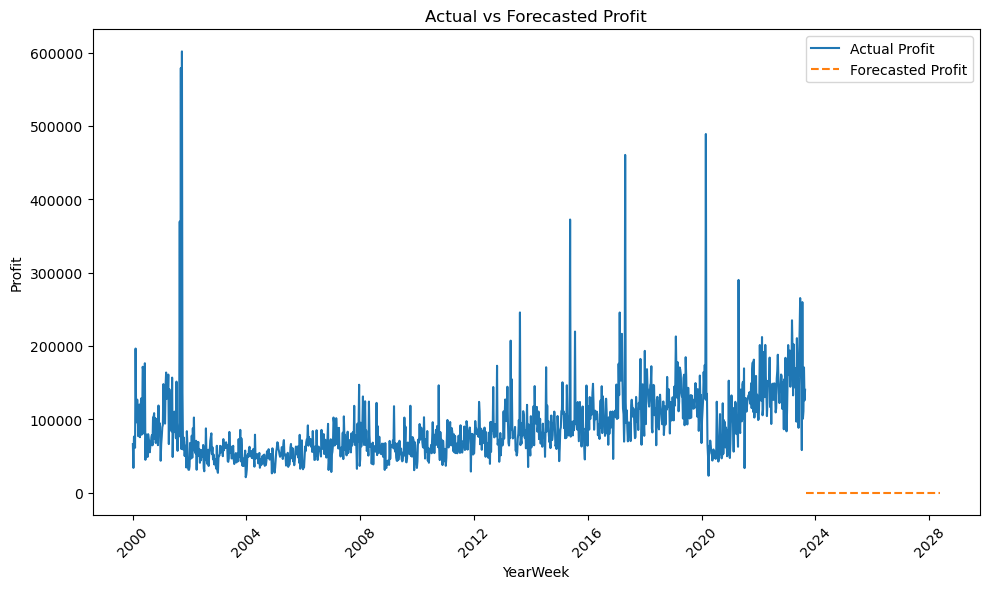

In [146]:
# Ensure 'YearWeek' and 'Profit' are one-dimensional arrays (NumPy)
yearweek_series = profit_grouped_df['YearWeek'].values  # Convert to 1D numpy array
profit_series = profit_grouped_df['Profit'].values      # Convert to 1D numpy array

n_periods = len(test)
# Generate forecast dates for the next 10 periods (weekly frequency) and convert to 1D array
forecast_dates = pd.date_range(yearweek_series[-1], periods=n_periods, freq='W').to_numpy()

# Ensure 'forecast' is a numpy array and 1D
forecast = np.array(forecast_seasonal).flatten()

# Plot actual data
plt.figure(figsize=(10, 6))
plt.plot(yearweek_series, profit_series, label='Actual Profit')

# Plot forecasted data using forecast dates
plt.plot(forecast_dates, forecast, label='Forecasted Profit', linestyle='--')

# Set labels and title
plt.xlabel('YearWeek')
plt.ylabel('Profit')
plt.title('Actual vs Forecasted Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

#### 2. Contract table

In [11]:
Contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215301 entries, 0 to 215300
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ContractId         215301 non-null  int64         
 1   AgentId            215301 non-null  int64         
 2   Office             215301 non-null  object        
 3   EventType          215301 non-null  object        
 4   ActType            215301 non-null  object        
 5   VenueName          215301 non-null  object        
 6   VenuePhysicalCity  215301 non-null  object        
 7   ContractDueDate    215301 non-null  datetime64[ns]
 8   Gross              215294 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 14.8+ MB


##### a. By Office

In [18]:
# Ensure 'ContractDueDate' is in datetime format
Contract_df['ContractDueDate'] = pd.to_datetime(Contract_df['ContractDueDate'])

# Step 1: Create a Year-Week column in the correct datetime format
Contract_df['YearWeek'] = Contract_df['ContractDueDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Step 2: Group by 'YearWeek' and 'Office', and sum 'Gross'
arima_Officedf = Contract_df.groupby(['YearWeek', 'Office'])['Gross'].sum().reset_index()

# Step 4: Handle NaN values in 'Gross' (if any) - this step is optional
arima_Officedf['Gross'] = arima_Officedf['Gross'].fillna(0)

# Step 5: Ensure 'YearWeek' is treated as a datetime index for ARIMA
arima_officedf = arima_Officedf.set_index('YearWeek', inplace=True)

In [19]:
arima_Officedf.head(5)

,Office,Gross
YearWeek,,
1999-12-27,ATL,56500.0
1999-12-27,RIC,22800.0
2000-01-03,ATL,51013.0
2000-01-03,CHS,19750.0
2000-01-03,CLT,83505.0


In [20]:
arima_Officedf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10650 entries, 1999-12-27 to 2024-07-15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Office  10650 non-null  object 
 1   Gross   10650 non-null  float64
dtypes: float64(1), object(1)
memory usage: 249.6+ KB


In [21]:
# Check the number of data points for each office
arima_Officedf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10650 entries, 1999-12-27 to 2024-07-15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Office  10650 non-null  object 
 1   Gross   10650 non-null  float64
dtypes: float64(1), object(1)
memory usage: 249.6+ KB


##### b. By Event Type

In [25]:
# Step 1: Group by 'YearWeek' and 'EventType', and sum 'Gross'
arima_EventTypedf = Contract_df.groupby(['YearWeek', 'EventType'])['Gross'].sum().reset_index()

# Step 2: Handle NaN values in 'Gross' (if any) - this step is optional
arima_EventTypedf['Gross'] = arima_EventTypedf['Gross'].fillna(0)

# Step 3: Ensure 'YearWeek' is treated as a datetime index for ARIMA
arima_EventTypedf.set_index('YearWeek', inplace=True)


In [27]:
arima_EventTypedf.head(5)

,EventType,Gross
YearWeek,,
1999-12-27,Christmas Party,450.0
1999-12-27,Club,1900.0
1999-12-27,Dance,21950.0
1999-12-27,Other,55000.0
2000-01-03,Banquet,7438.0


In [28]:
arima_EventTypedf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19759 entries, 1999-12-27 to 2024-07-15
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   EventType  19759 non-null  object 
 1   Gross      19759 non-null  float64
dtypes: float64(1), object(1)
memory usage: 463.1+ KB


##### b. By Act Type

In [29]:
# Step 1: Group by 'YearWeek' and 'EventType', and sum 'Gross'
arima_ActTypedf = Contract_df.groupby(['YearWeek', 'EventType'])['Gross'].sum().reset_index()

# Step 2: Handle NaN values in 'Gross' (if any) - this step is optional
arima_ActTypedf['Gross'] = arima_ActTypedf['Gross'].fillna(0)

# Step 3: Ensure 'YearWeek' is treated as a datetime index for ARIMA
arima_ActTypedf.set_index('YearWeek', inplace=True)

In [30]:
arima_ActTypedf.head()

,EventType,Gross
YearWeek,,
1999-12-27,Christmas Party,450.0
1999-12-27,Club,1900.0
1999-12-27,Dance,21950.0
1999-12-27,Other,55000.0
2000-01-03,Banquet,7438.0


In [31]:
arima_ActTypedf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19759 entries, 1999-12-27 to 2024-07-15
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   EventType  19759 non-null  object 
 1   Gross      19759 non-null  float64
dtypes: float64(1), object(1)
memory usage: 463.1+ KB
